In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Download data - FIXED: Handle MultiIndex properly
print("📥 Downloading data...")
data = yf.download(['KO', 'PEP'], start='2020-01-01', end='2023-12-31')

print("✅ Data downloaded successfully!")
print(f"Data shape: {data.shape}")
print(f"Data columns: {data.columns}")

# 2. Extract just the Close prices from the MultiIndex
close_prices = data['Close']  # This gives us a DataFrame with KO and PEP columns
print(f"\n📊 Close prices shape: {close_prices.shape}")
print(f"📊 Close prices columns: {close_prices.columns}")

C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_22476\46780496.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(['KO', 'PEP'], start='2020-01-01', end='2023-12-31')
[*********************100%***********************]  2 of 2 completed

📥 Downloading data...
✅ Data downloaded successfully!
Data shape: (1006, 10)
Data columns: MultiIndex([( 'Close',  'KO'),
            ( 'Close', 'PEP'),
            (  'High',  'KO'),
            (  'High', 'PEP'),
            (   'Low',  'KO'),
            (   'Low', 'PEP'),
            (  'Open',  'KO'),
            (  'Open', 'PEP'),
            ('Volume',  'KO'),
            ('Volume', 'PEP')],
           names=['Price', 'Ticker'])

📊 Close prices shape: (1006, 2)
📊 Close prices columns: Index(['KO', 'PEP'], dtype='object', name='Ticker')


📊 Correlation between KO and PEP: 0.935


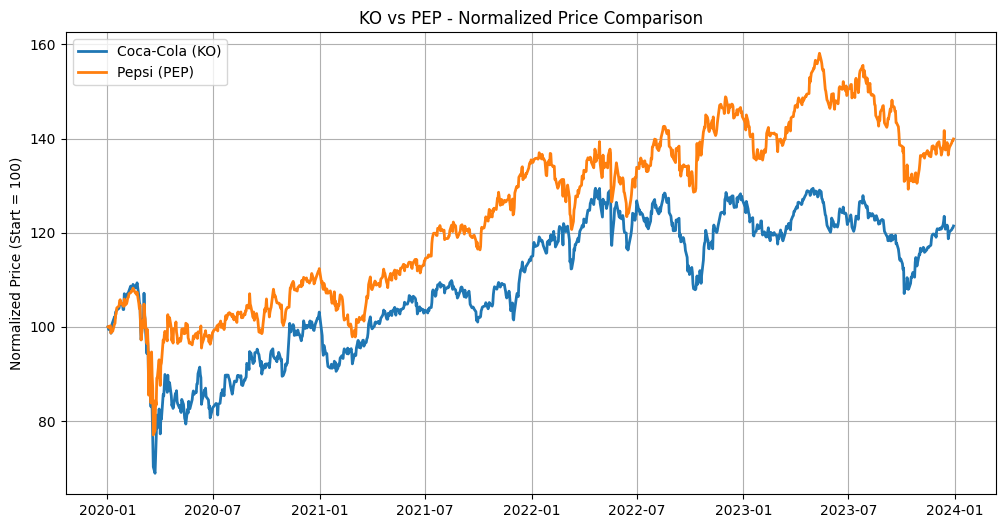

✅ Strong correlation! Good candidate for pairs trading.


In [19]:
# 3. Check correlation - NOW THIS WILL WORK!
correlation = close_prices['KO'].corr(close_prices['PEP'])
print(f"📊 Correlation between KO and PEP: {correlation:.3f}")


# 4. Plot normalized prices
plt.figure(figsize=(12, 6))
close_normalized = (close_prices / close_prices.iloc[0]) * 100
plt.plot(close_normalized['KO'], label='Coca-Cola (KO)', linewidth=2)
plt.plot(close_normalized['PEP'], label='Pepsi (PEP)', linewidth=2)
plt.title('KO vs PEP - Normalized Price Comparison')
plt.ylabel('Normalized Price (Start = 100)')
plt.legend()
plt.grid(True)
plt.show()

# Interpretation
if correlation > 0.7:
    print("✅ Strong correlation! Good candidate for pairs trading.")
elif correlation > 0.5:
    print("📗 Moderate correlation. Might work for pairs trading.")
else:
    print("❌ Weak correlation. Not ideal for pairs trading.")

C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_22476\3234487045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices['Spread'] = close_prices['KO'] - close_prices['PEP']


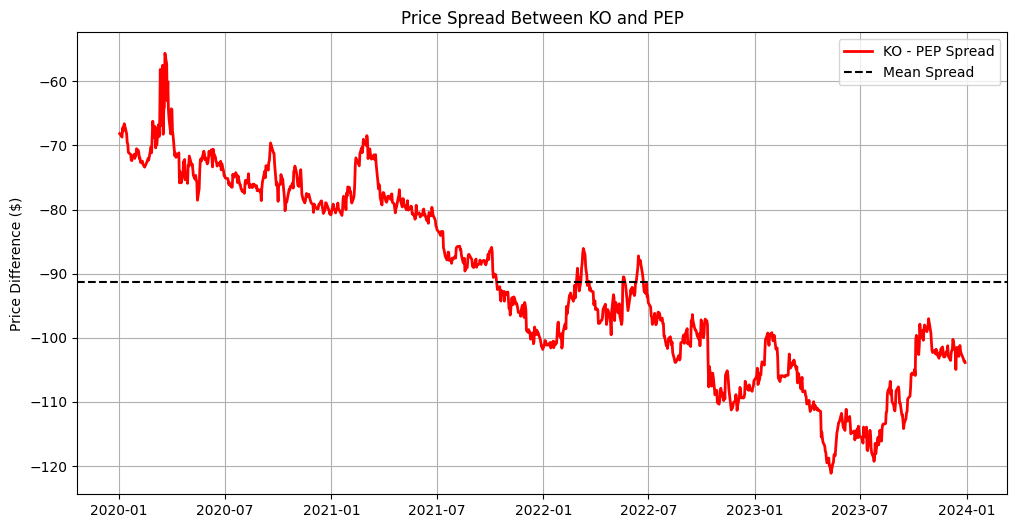

📊 Spread Statistics:
Mean spread: $-91.34
Std deviation: $14.72


In [20]:
# Calculate the spread
close_prices['Spread'] = close_prices['KO'] - close_prices['PEP']

# Plot the spread
plt.figure(figsize=(12, 6))
plt.plot(close_prices['Spread'], label='KO - PEP Spread', color='red', linewidth=2)
plt.axhline(y=close_prices['Spread'].mean(), color='black', linestyle='--', label='Mean Spread')
plt.title('Price Spread Between KO and PEP')
plt.ylabel('Price Difference ($)')
plt.legend()
plt.grid(True)
plt.show()

print(f"📊 Spread Statistics:")
print(f"Mean spread: ${close_prices['Spread'].mean():.2f}")
print(f"Std deviation: ${close_prices['Spread'].std():.2f}")

### 🎯 CREATE TRADING SIGNALS


In [23]:
# 6. Calculate z-score and create signals
close_prices['Spread_Z'] = (close_prices['Spread'] - close_prices['Spread'].mean()) / close_prices['Spread'].std()

# Create signals
close_prices['Signal'] = 0
close_prices['Signal'] = np.where(close_prices['Spread_Z'] > 1, -1, close_prices['Signal'])  # SELL KO, BUY PEP
close_prices['Signal'] = np.where(close_prices['Spread_Z'] < -1, 1, close_prices['Signal'])   # BUY KO, SELL PEP
close_prices['Signal'] = np.where(abs(close_prices['Spread_Z']) < 0.5, 0, close_prices['Signal'])  # EXIT

print("🎯 Signal Distribution:")
print(close_prices['Signal'].value_counts().sort_index())
print("\nSignal Meaning:")
print(" 1 = Buy KO / Sell PEP (Spread is low)")
print("-1 = Sell KO / Buy PEP (Spread is high)") 
print(" 0 = No position")

🎯 Signal Distribution:
Signal
-1    225
 0    590
 1    191
Name: count, dtype: int64

Signal Meaning:
 1 = Buy KO / Sell PEP (Spread is low)
-1 = Sell KO / Buy PEP (Spread is high)
 0 = No position


C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_22476\1242343694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices['Spread_Z'] = (close_prices['Spread'] - close_prices['Spread'].mean()) / close_prices['Spread'].std()
C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_22476\1242343694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices['Signal'] = 0
C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_22476\1242343694.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy

### 📊 VISUALIZE THE STRATEGY


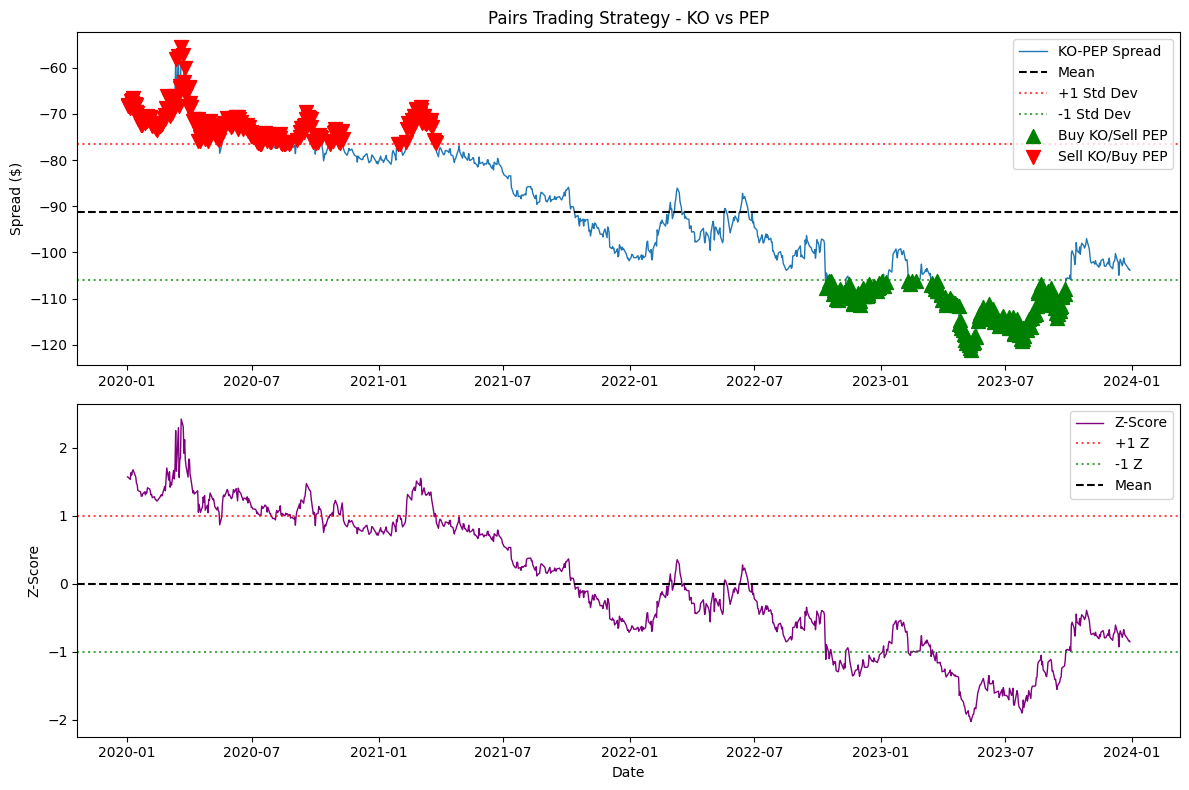

In [25]:
# 7. Plot the strategy
plt.figure(figsize=(12, 8))

# Plot 1: Spread with trading signals
plt.subplot(2, 1, 1)
plt.plot(close_prices['Spread'], label='KO-PEP Spread', linewidth=1)
plt.axhline(y=close_prices['Spread'].mean(), color='black', linestyle='--', label='Mean')
plt.axhline(y=close_prices['Spread'].mean() + close_prices['Spread'].std(), color='red', linestyle=':', alpha=0.7, label='+1 Std Dev')
plt.axhline(y=close_prices['Spread'].mean() - close_prices['Spread'].std(), color='green', linestyle=':', alpha=0.7, label='-1 Std Dev')

# Mark buy/sell signals
buy_signals = close_prices[close_prices['Signal'] == 1]
sell_signals = close_prices[close_prices['Signal'] == -1]

plt.scatter(buy_signals.index, buy_signals['Spread'], color='green', marker='^', s=100, label='Buy KO/Sell PEP', zorder=5)
plt.scatter(sell_signals.index, sell_signals['Spread'], color='red', marker='v', s=100, label='Sell KO/Buy PEP', zorder=5)

plt.title('Pairs Trading Strategy - KO vs PEP')
plt.legend()
plt.ylabel('Spread ($)')

# Plot 2: Z-score
plt.subplot(2, 1, 2)
plt.plot(close_prices['Spread_Z'], label='Z-Score', color='purple', linewidth=1)
plt.axhline(y=1, color='red', linestyle=':', alpha=0.7, label='+1 Z')
plt.axhline(y=-1, color='green', linestyle=':', alpha=0.7, label='-1 Z')
plt.axhline(y=0, color='black', linestyle='--', label='Mean')
plt.legend()
plt.ylabel('Z-Score')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

### 🚀 CALCULATE THE RETURNS

In [26]:
# Calculate returns for each stock
close_prices['KO_Returns'] = close_prices['KO'].pct_change()
close_prices['PEP_Returns'] = close_prices['PEP'].pct_change()

# Calculate strategy returns
# When Signal = 1: Buy KO, Sell PEP (we profit if KO outperforms PEP)
# When Signal = -1: Sell KO, Buy PEP (we profit if PEP outperforms KO) 
# When Signal = 0: No position (0 returns)

close_prices['Strategy_Returns'] = 0.0

# Long KO / Short PEP
close_prices['Strategy_Returns'] = np.where(
    close_prices['Signal'].shift(1) == 1,
    close_prices['KO_Returns'] - close_prices['PEP_Returns'],
    close_prices['Strategy_Returns']
)

# Short KO / Long PEP  
close_prices['Strategy_Returns'] = np.where(
    close_prices['Signal'].shift(1) == -1, 
    close_prices['PEP_Returns'] - close_prices['KO_Returns'],
    close_prices['Strategy_Returns']
)

# Remove missing values
close_prices = close_prices.dropna()

# Calculate cumulative returns
close_prices['Cumulative_Strategy'] = (1 + close_prices['Strategy_Returns']).cumprod()
close_prices['Cumulative_KO'] = (1 + close_prices['KO_Returns']).cumprod()
close_prices['Cumulative_PEP'] = (1 + close_prices['PEP_Returns']).cumprod()

# Calculate final performance
final_strategy = (close_prices['Cumulative_Strategy'].iloc[-1] - 1) * 100
final_ko = (close_prices['Cumulative_KO'].iloc[-1] - 1) * 100
final_pep = (close_prices['Cumulative_PEP'].iloc[-1] - 1) * 100

print("🎯 STRATEGY PERFORMANCE RESULTS:")
print("=" * 40)
print(f"Pairs Trading Strategy: {final_strategy:.2f}%")
print(f"Buy-and-Hold KO: {final_ko:.2f}%")
print(f"Buy-and-Hold PEP: {final_pep:.2f}%")
print(f"Average Stock: {((final_ko + final_pep) / 2):.2f}%")

🎯 STRATEGY PERFORMANCE RESULTS:
Pairs Trading Strategy: 25.38%
Buy-and-Hold KO: 21.42%
Buy-and-Hold PEP: 39.90%
Average Stock: 30.66%


C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_22476\2287221561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices['KO_Returns'] = close_prices['KO'].pct_change()
C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_22476\2287221561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices['PEP_Returns'] = close_prices['PEP'].pct_change()
C:\Users\Aadya Nair\AppData\Local\Temp\ipykernel_22476\2287221561.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

### 📈 PLOT THE RESULTS


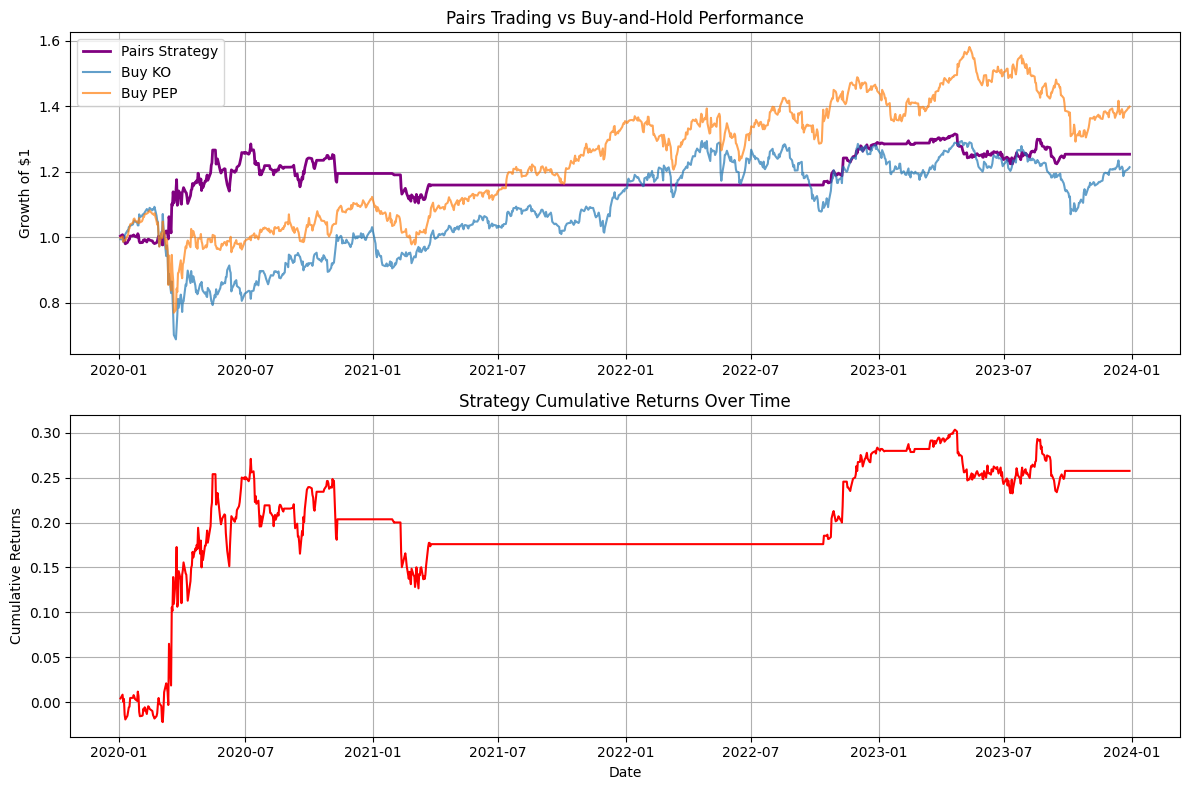

In [27]:
# Plot performance comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(close_prices['Cumulative_Strategy'], label='Pairs Strategy', linewidth=2, color='purple')
plt.plot(close_prices['Cumulative_KO'], label='Buy KO', alpha=0.7)
plt.plot(close_prices['Cumulative_PEP'], label='Buy PEP', alpha=0.7)
plt.title('Pairs Trading vs Buy-and-Hold Performance')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(close_prices['Strategy_Returns'].cumsum(), label='Strategy Cumulative Returns', color='red')
plt.title('Strategy Cumulative Returns Over Time')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()
plt.show()

### 🔍 ANALYZE STRATEGY CHARACTERISTICS


In [28]:
# Calculate some key metrics
annual_return = final_strategy / 4  # Rough annualized (4 years)
volatility = close_prices['Strategy_Returns'].std() * np.sqrt(252) * 100
sharpe_ratio = annual_return / volatility if volatility > 0 else 0

print(f"\n📊 RISK-ADJUSTED METRICS:")
print(f"Annual Volatility: {volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Win Rate: {(close_prices['Strategy_Returns'] > 0).mean() * 100:.1f}%")

# Check maximum drawdown
running_max = close_prices['Cumulative_Strategy'].expanding().max()
drawdown = (close_prices['Cumulative_Strategy'] - running_max) / running_max
max_drawdown = drawdown.min() * 100
print(f"Maximum Drawdown: {max_drawdown:.2f}%")


📊 RISK-ADJUSTED METRICS:
Annual Volatility: 12.58%
Sharpe Ratio: 0.50
Win Rate: 22.1%
Maximum Drawdown: -14.04%


### 🚀 DEEPER ANALYSIS


🔍 TRADE ANALYSIS:
Total trading days: 416
Winning trades: 222 (53.4%)
Losing trades: 194 (46.6%)
Average win: 0.7790%
Average loss: -0.7586%
Profit factor: 1.18


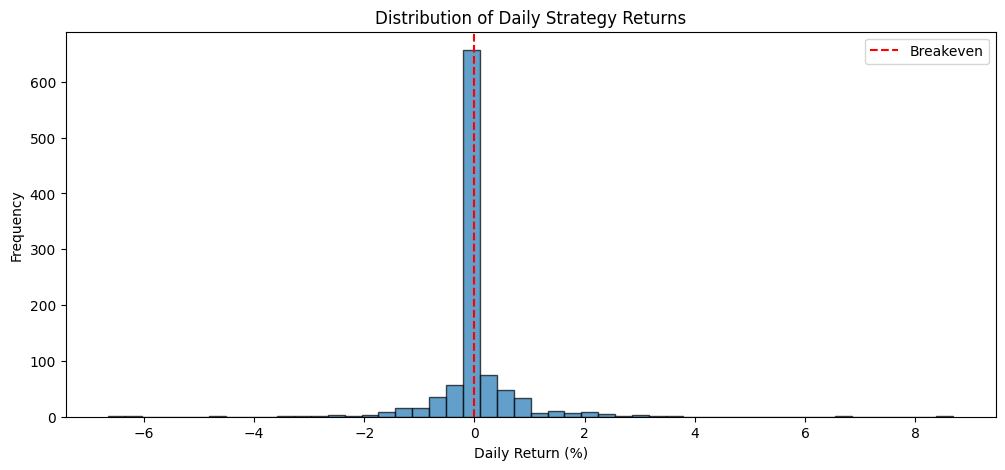

In [29]:
# Analyze trade performance
trading_days = close_prices[close_prices['Signal'].shift(1) != 0]  # Days we were in a trade
winning_trades = trading_days[trading_days['Strategy_Returns'] > 0]
losing_trades = trading_days[trading_days['Strategy_Returns'] < 0]

print("\n🔍 TRADE ANALYSIS:")
print(f"Total trading days: {len(trading_days)}")
print(f"Winning trades: {len(winning_trades)} ({len(winning_trades)/len(trading_days)*100:.1f}%)")
print(f"Losing trades: {len(losing_trades)} ({len(losing_trades)/len(trading_days)*100:.1f}%)")

if len(winning_trades) > 0 and len(losing_trades) > 0:
    avg_win = winning_trades['Strategy_Returns'].mean() * 100
    avg_loss = losing_trades['Strategy_Returns'].mean() * 100
    profit_factor = (avg_win * len(winning_trades)) / abs(avg_loss * len(losing_trades))
    
    print(f"Average win: {avg_win:.4f}%")
    print(f"Average loss: {avg_loss:.4f}%") 
    print(f"Profit factor: {profit_factor:.2f}")

# Plot daily returns distribution
plt.figure(figsize=(12, 5))
plt.hist(close_prices['Strategy_Returns'] * 100, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Breakeven')
plt.title('Distribution of Daily Strategy Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.show()